In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Keep this in case you need it later for statistical tests
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep # Also for later tests

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define the path where the processed data is saved
processed_data_path = r'C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed'
input_file_name = 'df_full_ab_test_cleaned.csv'
input_full_path = os.path.join(processed_data_path, input_file_name)

# Load the cleaned and merged DataFrame
try:
    df_full_ab_test = pd.read_csv(input_full_path)
    # Ensure 'date_time' is re-converted to datetime objects after loading from CSV
    df_full_ab_test['date_time'] = pd.to_datetime(df_full_ab_test['date_time'])
    print(f"Successfully loaded df_full_ab_test from: {input_full_path}")
    print(f"df_full_ab_test info after loading:")
    df_full_ab_test.info() # Verify data types
    
    # --- Additional Cleaning for Numerical Demographic Columns after CSV Load ---
    

    # Print initial NaNs in relevant columns BEFORE any further action in this notebook
    print("\nNaNs in demographic columns of df_full_ab_test (after loading, before current cleaning):")
    print(df_full_ab_test[['clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']].isnull().sum())

    # drop NaNs rows, as a client without full demographic data isn't fully profiled.
    initial_ab_test_rows = len(df_full_ab_test)
    df_full_ab_test.dropna(subset=[
    'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
    'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'
    ], inplace=True)

    print(f"\nRemoved {initial_ab_test_rows - len(df_full_ab_test)} rows with NaNs in demographic columns.")
    print(f"df_full_ab_test now has {len(df_full_ab_test)} entries after this cleaning.")

    # Verify no more NaNs in these columns
    print("\nNaNs in demographic columns of df_full_ab_test (after current cleaning):")
    print(df_full_ab_test[['clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']].isnull().sum())

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Make sure '{input_file_name}' was saved correctly from the previous notebook.")
    exit() # Exit if the file isn't found, as subsequent steps will fail




Successfully loaded df_full_ab_test from: C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed\df_full_ab_test_cleaned.csv
df_full_ab_test info after loading:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302397 entries, 0 to 302396
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         302397 non-null  int64         
 1   visitor_id        302397 non-null  object        
 2   visit_id          302397 non-null  object        
 3   process_step      302397 non-null  object        
 4   date_time         302397 non-null  datetime64[ns]
 5   variation         302397 non-null  object        
 6   clnt_tenure_yr    302289 non-null  float64       
 7   clnt_tenure_mnth  302289 non-null  float64       
 8   clnt_age          302289 non-null  float64       
 9   gendr             302289 non-null  object        
 10  num_accts         302289 non-null  float6


--- Starting Performance Metrics (KPI) Calculation ---

--- KPI 1: Completion Rate ---
Completion Rates per Variation:
variation
Control    49.886769
Test       58.577575
Name: True, dtype: float64


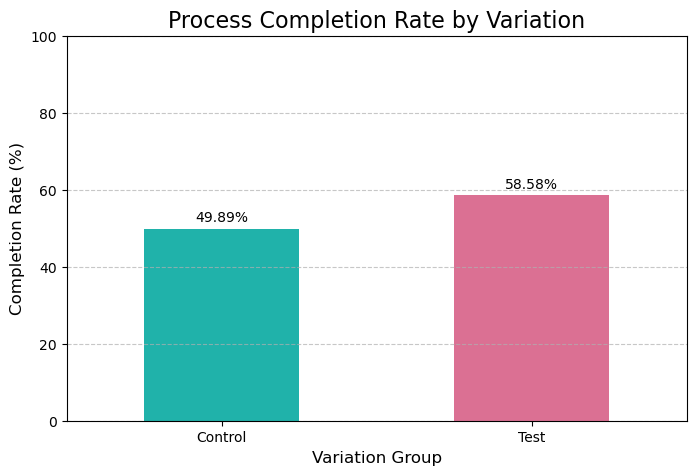


Test Group: 21785 completions out of 37190 visits.
Control Group: 16081 completions out of 32235 visits.

--- KPI 2: Average Time Spent to Complete Process ---
Average Time Spent (minutes) per Completed Process by Variation:
variation
Control    6.668988
Test       6.889452
Name: duration_minutes, dtype: float64


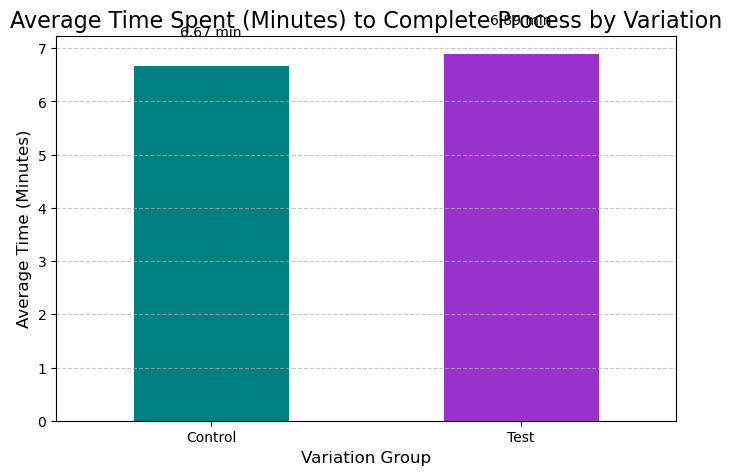


--- KPI 3: Error Rate / Backward Movement ---


C:\Users\Mahmoud Gobran\AppData\Local\Temp\ipykernel_18836\3478137363.py:128: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  visits_with_backward_movement = df_full_ab_test.groupby(['client_id', 'visit_id', 'variation']).apply(detect_backward_movement).reset_index(name='has_backward_movement')


Error Rates (Percentage of visits with backward movement) per Variation:
variation
Control    62.596557
Test       69.333154
Name: True, dtype: float64


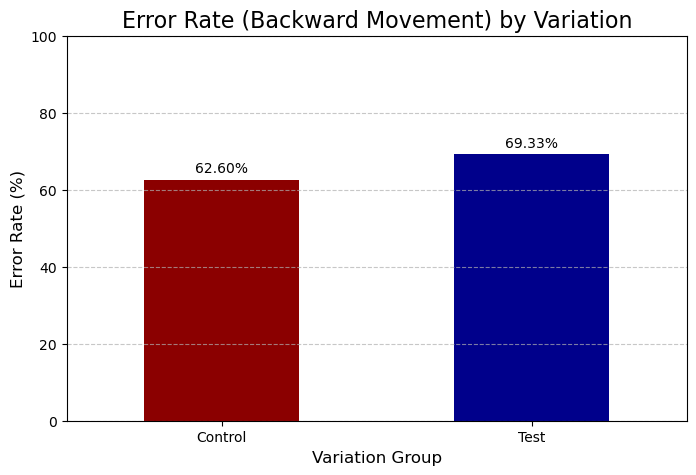


Test Group: 25785 visits with backward movement out of 37190 total visits.
Control Group: 20178 visits with backward movement out of 32235 total visits.

--- KPI Calculation Complete ---


In [ ]:
print("\n--- Starting Performance Metrics (KPI) Calculation ---")

# --- Helper Function for Process Step Order ---
# This dictionary maps process steps to a numerical order.
# This is crucial for identifying completion and backward movements.
process_step_order = {
    'start': 0,
    'step_1': 1,
    'step_2': 2,
    'step_3': 3,
    'confirm': 4
}
# Map the 'process_step' column to its numerical order
df_full_ab_test['step_order'] = df_full_ab_test['process_step'].map(process_step_order)


### KPI 1: Completion Rate ###
print("\n--- KPI 1: Completion Rate ---")

# A client is considered to have completed the process if their max_step_order is 'confirm' (4)
# First, find the maximum step reached by each client for each visit.
# It's important to group by client_id AND visit_id because a client can have multiple visits.
# A completion means completing a *single visit*.

# Find the maximum step order for each client and visit
max_steps_per_visit = df_full_ab_test.groupby(['client_id', 'visit_id', 'variation'])['step_order'].max().reset_index()
max_steps_per_visit.rename(columns={'step_order': 'max_step_order'}, inplace=True)

# Determine if a visit resulted in completion (reached 'confirm' step, which is order 4)
max_steps_per_visit['completed'] = (max_steps_per_visit['max_step_order'] == 4)

# Calculate completion rate per variation
completion_rates = max_steps_per_visit.groupby('variation')['completed'].value_counts(normalize=True).unstack(fill_value=0)

# If 'True' and 'False' columns exist, pick 'True' which means completion
if True in completion_rates.columns:
    completion_rates_final = completion_rates[True] * 100
else: # Case where a group might have 0 completions
    completion_rates_final = pd.Series(0.0, index=completion_rates.index) # Initialize with 0% if no completions

print("Completion Rates per Variation:")
print(completion_rates_final)


# Visualize Completion Rates
plt.figure(figsize=(8, 5))
completion_rates_final.plot(kind='bar', color=['lightseagreen', 'palevioletred'])
plt.title('Process Completion Rate by Variation', fontsize=16)
plt.xlabel('Variation Group', fontsize=12)
plt.ylabel('Completion Rate (%)', fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=0)
for index, value in enumerate(completion_rates_final):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Store completion counts for hypothesis testing later
completions_test = completion_rates.loc['Test', True] * max_steps_per_visit['variation'].value_counts()['Test'] if True in completion_rates.columns else 0
attempts_test = max_steps_per_visit['variation'].value_counts()['Test']
completions_control = completion_rates.loc['Control', True] * max_steps_per_visit['variation'].value_counts()['Control'] if True in completion_rates.columns else 0
attempts_control = max_steps_per_visit['variation'].value_counts()['Control']

print(f"\nTest Group: {int(completions_test)} completions out of {int(attempts_test)} visits.")
print(f"Control Group: {int(completions_control)} completions out of {int(attempts_control)} visits.")


### KPI 2: Average Time Spent to Complete Process ###
print("\n--- KPI 2: Average Time Spent to Complete Process ---")

# Filter for only completed visits (max_step_order == 4)
completed_visits = max_steps_per_visit[max_steps_per_visit['completed'] == True].copy() 

if not completed_visits.empty:
    # Merge back with the full data to get timestamps for completed visits
    # This join will keep only the completed client_id, visit_id pairs
    df_completed_steps = pd.merge(df_full_ab_test, completed_visits[['client_id', 'visit_id']],
                                  on=['client_id', 'visit_id'], how='inner')

    # For each completed visit, find the start time and end time
    # Start time is the 'start' step (order 0), End time is the 'confirm' step (order 4)
    start_times = df_completed_steps[df_completed_steps['step_order'] == 0].groupby(['client_id', 'visit_id'])['date_time'].min()
    end_times = df_completed_steps[df_completed_steps['step_order'] == 4].groupby(['client_id', 'visit_id'])['date_time'].max()

    # Calculate duration for each completed visit
    duration_per_visit = (end_times - start_times).dt.total_seconds() / 60 # Duration in minutes

    # Merge durations back to completed_visits to get the variation
    completed_visits_with_duration = pd.merge(completed_visits, duration_per_visit.rename('duration_minutes'),
                                              on=['client_id', 'visit_id'])

    # Calculate average duration per variation
    average_duration_per_variation = completed_visits_with_duration.groupby('variation')['duration_minutes'].mean()
    print("Average Time Spent (minutes) per Completed Process by Variation:")
    print(average_duration_per_variation)

    # Visualize Average Time Spent
    plt.figure(figsize=(8, 5))
    average_duration_per_variation.plot(kind='bar', color=['teal', 'darkorchid'])
    plt.title('Average Time Spent (Minutes) to Complete Process by Variation', fontsize=16)
    plt.xlabel('Variation Group', fontsize=12)
    plt.ylabel('Average Time (Minutes)', fontsize=12)
    plt.xticks(rotation=0)
    for index, value in enumerate(average_duration_per_variation):
        plt.text(index, value + 0.5, f'{value:.2f} min', ha='center', va='bottom', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

else:
    print("No completed visits found for time spent calculation.")


### KPI 3: Error Rate / Backward Movement ###
print("\n--- KPI 3: Error Rate / Backward Movement ---")

# Define a function to detect backward movements within a visit
def detect_backward_movement(df_visit):
    # Sort by date_time to ensure correct order
    df_visit = df_visit.sort_values(by='date_time')
    # Calculate the difference in step_order for consecutive steps
    df_visit['step_diff'] = df_visit['step_order'].diff()
    # A backward movement occurs if step_diff is negative
    return (df_visit['step_diff'] < 0).any()

# Apply the function to each visit group
# This will iterate through each client_id and visit_id combination
visits_with_backward_movement = df_full_ab_test.groupby(['client_id', 'visit_id', 'variation']).apply(detect_backward_movement).reset_index(name='has_backward_movement')

# Calculate the proportion of visits with backward movement per variation
error_rates = visits_with_backward_movement.groupby('variation')['has_backward_movement'].value_counts(normalize=True).unstack(fill_value=0)

# The 'True' column indicates visits with backward movement (errors)
if True in error_rates.columns:
    error_rates_final = error_rates[True] * 100
else: # Case where a group might have 0 errors
    error_rates_final = pd.Series(0.0, index=error_rates.index) # Initialize with 0% if no errors


print("Error Rates (Percentage of visits with backward movement) per Variation:")
print(error_rates_final)

# Visualize Error Rates
plt.figure(figsize=(8, 5))
error_rates_final.plot(kind='bar', color=['darkred', 'darkblue'])
plt.title('Error Rate (Backward Movement) by Variation', fontsize=16)
plt.xlabel('Variation Group', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=0)
for index, value in enumerate(error_rates_final):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Store error counts for hypothesis testing later
errors_test = error_rates.loc['Test', True] * visits_with_backward_movement['variation'].value_counts()['Test'] if True in error_rates.columns else 0
total_visits_test = visits_with_backward_movement['variation'].value_counts()['Test']
errors_control = error_rates.loc['Control', True] * visits_with_backward_movement['variation'].value_counts()['Control'] if True in error_rates.columns else 0
total_visits_control = visits_with_backward_movement['variation'].value_counts()['Control']

print(f"\nTest Group: {int(errors_test)} visits with backward movement out of {int(total_visits_test)} total visits.")
print(f"Control Group: {int(errors_control)} visits with backward movement out of {int(total_visits_control)} total visits.")

print("\n--- KPI Calculation Complete ---")

In [8]:
def quick_data_report(df, file_path="df_name.txt", max_unique=50):
    with open(file_path, "w", encoding="utf-8") as f:
        def p(*args): print(*args, file=f)

        p("=== Shape (rows, columns) ===")
        p(df.shape)

        p("\n=== Column Names ===")
        p(df.columns.tolist())

        p("\n=== Data Types ===")
        p(df.dtypes)

        p("\n=== Missing Values (per column) ===")
        p(df.isnull().sum())

        p("\n=== Duplicate Rows ===")
        p(df.duplicated().sum())

        p("\n=== Unique Values (per column) ===")
        p(df.nunique())

        p("\n=== DataFrame Info ===")
        df.info(buf=f)

        p("\n=== Descriptive Statistics (including non-numeric) ===")
        p(df.describe(include='all'))

        p("\n=== First 5 Rows ===")
        p(df.head())

        p("\n=== Last 5 Rows ===")
        p(df.tail())

        p("\n=== Random Sample of 5 Rows ===")
        p(df.sample(5))

        p("\n=== Value Counts (for columns with 50 or fewer unique values) ===")
        for col in df.columns:
            if df[col].nunique() <= max_unique:
                p(f"\n--- {col} ---")
                p(df[col].value_counts())


In [10]:
quick_data_report(df_full_ab_test, file_path="report_df_full_ab_test.txt")
quick_data_report(df_completed_steps, file_path="report_df_completed_steps.txt")
#quick_data_report(df_visit, file_path="report_df_visit.txt")


